# Lab 2: Cats vs Dogs

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1WbgA47qi1awq-MrfuyVA_lCvBt82aXvk?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [1]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

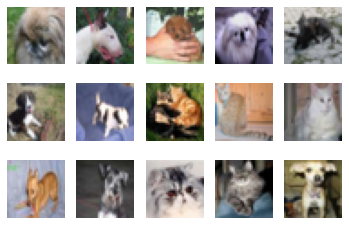

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print("number of training examples:",len(train_loader))
print("number of validation examples:",len(val_loader))
print("number of test examples:",len(test_loader))
# There are 8000 training examples, 2000 validation examples and 2000 testing examples.

number of training examples: 8000
number of validation examples: 2000
number of test examples: 2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

In [ ]:
"""
Validation set is a separate data set which can provide information that helps us 
to tune the hyperparameters of the model and improve the accurancy.

If we judge the performance of our models using the training set, we may not get the
best model because of overfitting.
"""

'\nValidation set is a separate data set which can provide information that helps us \nto tune the hyperparameters of the model and improve the accurancy.\n\nIf we judge the performance of our models using the training set, we may not get the\nbest model because of overfitting.\n'

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
for param in small_net.parameters():
    print(param.shape)
print("---------------")
for param in large_net.parameters():
    print(param.shape)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
---------------
torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])


Total number of parameters in small_net = 5*3*3*3 + 5 + 245*1 + 1 = 386

Total number of parameters in large_net = 5*3*5*5 + 5 + 10*5*5*5 + 10 + 32*250 + 32 + 32*1 + 1 = 9705


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# batch_size=64, learning_rate=0.01, num_epochs=30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, 64, 0.01, 5)
# """
# The files written to disk:
# - train_err.csv: contains the values on the train error of the training model for each epoch
# - train_loss.csv: contains the values on the train loss of the training model for each epoch
# - val_err.csv: contains the values on the validation error of the training model for each epoch
# - val_loss.csv: contains the values on the validation loss of the training model for each epoch
# """

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423625, Train loss: 0.673694806098938 |Validation err: 0.374, Validation loss: 0.656715203076601
Epoch 2: Train err: 0.3645, Train loss: 0.6456965618133544 |Validation err: 0.3735, Validation loss: 0.6565265655517578
Epoch 3: Train err: 0.349, Train loss: 0.6302225260734559 |Validation err: 0.344, Validation loss: 0.6247318014502525
Epoch 4: Train err: 0.3365, Train loss: 0.613285131931305 |Validation err: 0.361, Validation loss: 0.6296746470034122
Epoch 5: Train err: 0.325625, Train loss: 0.604389997959137 |Validation err: 0.337, Validation loss: 0.617976725101471
Finished Training
Total time elapsed: 18.54 seconds


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.32125, Train loss: 0.5968205292224884 |Validation err: 0.328, Validation loss: 0.6146028693765402
Epoch 2: Train err: 0.314625, Train loss: 0.5893487687110901 |Validation err: 0.325, Validation loss: 0.6163586601614952
Epoch 3: Train err: 0.305125, Train loss: 0.5818272852897644 |Validation err: 0.324, Validation loss: 0.6023563370108604
Epoch 4: Train err: 0.302625, Train loss: 0.5765725989341736 |Validation err: 0.336, Validation loss: 0.6054455637931824
Epoch 5: Train err: 0.29675, Train loss: 0.5686763379573821 |Validation err: 0.3125, Validation loss: 0.5934370504692197
Epoch 6: Train err: 0.2895, Train loss: 0.5643935697078705 |Validation err: 0.315, Validation loss: 0.5909331701695919
Epoch 7: Train err: 0.2965, Train loss: 0.5636018862724305 |Validation err: 0.315, Validation loss: 0.5875732693821192
Epoch 8: Train err: 0.28425, Train loss: 0.5568224539756775 |Validation err: 0.314

In [ ]:
train_net(large_net)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.464625, Train loss: 0.6918211150169372 |Validation err: 0.4385, Validation loss: 0.6867818627506495
Epoch 2: Train err: 0.4335, Train loss: 0.6809519610404968 |Validation err: 0.4025, Validation loss: 0.6747796069830656
Epoch 3: Train err: 0.404375, Train loss: 0.6638261690139771 |Validation err: 0.37, Validation loss: 0.6439390871673822
Epoch 4: Train err: 0.3685, Train loss: 0.6416776561737061 |Validation err: 0.38, Validation loss: 0.6470333933830261
Epoch 5: Train err: 0.34525, Train loss: 0.6241806783676147 |Validation err: 0.327, Validation loss: 0.6145599596202374
Epoch 6: Train err: 0.336, Train loss: 0.6085597445964813 |Validation err: 0.3285, Validation loss: 0.6097845286130905
Epoch 7: Train err: 0.32075, Train loss: 0.5938914704322815 |Validation err: 0.327, Validation loss: 0.5954362526535988
Epoch 8: Train err: 0.3075, Train loss: 0.5768407340049744 |Validation err: 0.313, Va

Total time elapsed for small_net is 104.51 seconds

Total time elapsed for large_net is 115.67 seconds

small_net is faster than large_bet because it has less parameters.It requires less time to do calculations  

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

training curve for small network:


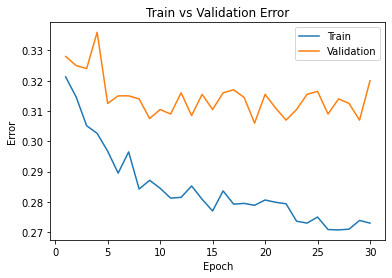

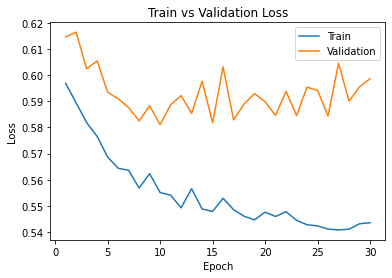

training curve for large network:


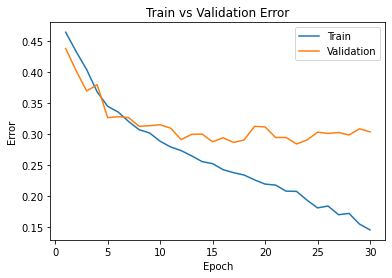

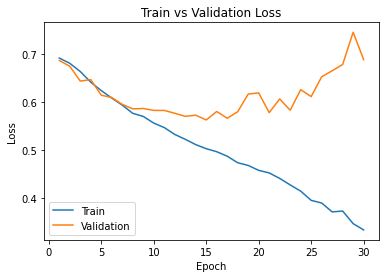

In [ ]:
small_net_model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
large_net_model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)

print("training curve for small network:")
plot_training_curve(small_net_model_path)

print("training curve for large network:")
plot_training_curve(large_net_model_path)


### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

In [ ]:
# For small net, the model is underfitting at the beginning, the error and loss are very large.
# As the epoch increases, the error and loss of training and validation decreases and tends to flaten.
# Training error and loss are lower than validation error and loss.
# These show that the small net is a good fitting model.

# For large net, training loss/error curves are much smoother (with less variation). 
# As the epoch increases, validation error stays around the same and the validation error increases.
# These show that the large net is overfitting.

# The small net is better fitting than the large net.

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, 64, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

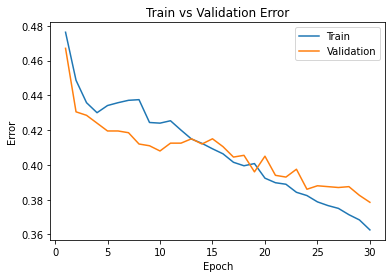

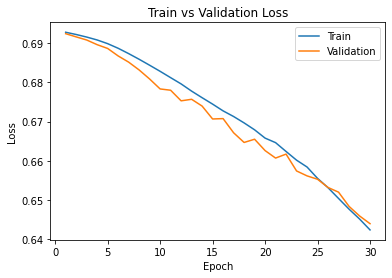

In [ ]:
model_path_large  = get_model_name("large", batch_size = 64, learning_rate = 0.001, epoch = 29)
plot_training_curve(model_path_large )

The model takes more time to train than the previous model (5 more seconds)

Comparing the curves with before, it is obvious that the large net with new learning rate is better fitting without overfitting. By lowing the learning rate, the model's accurancy and performance are improved.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

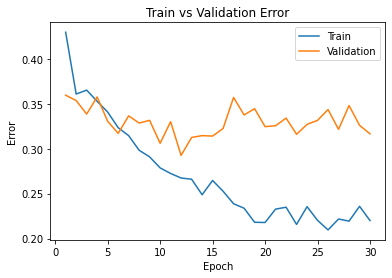

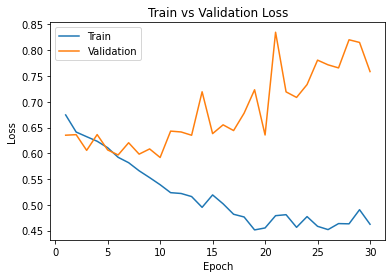

In [ ]:
model_path_large  = get_model_name("large", batch_size = 64, learning_rate = 0.1, epoch = 29)
plot_training_curve(model_path_large )

The model takes more time to train than the original model (4 more seconds) and less time than the last model (1 less second).

The curves reflect that the model is overfitting again. The validation error and loss increases as the epoch increases.

Comparing the curves with before, it is obvious that increasing the learning rate to 0.1 is not a good choice because it would lead to overfit.



### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

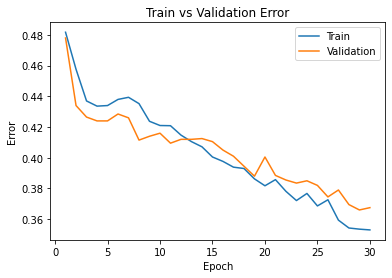

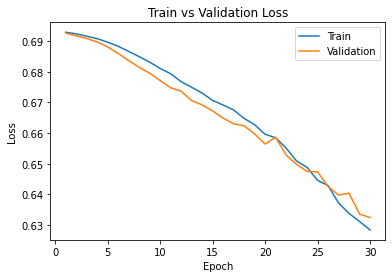

In [ ]:
model_path_large  = get_model_name("large", batch_size = 512, learning_rate = 0.01, epoch = 29)
plot_training_curve(model_path_large )

The model takes less time to train than the original model (12 less seconds) because as the increase of batch size, times of iteration of 1 epoch is shorter.

Increasing the batch size can make the model fit the data better without overfitting.The loss and error decreases as the epoch increases.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

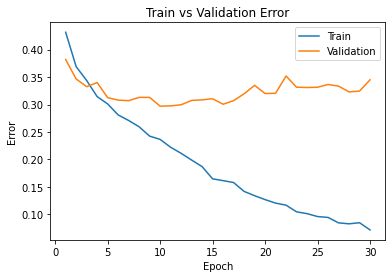

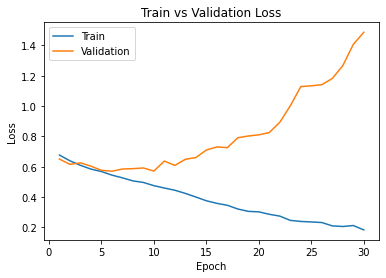

In [ ]:
model_path_large  = get_model_name("large", batch_size = 16, learning_rate = 0.01, epoch = 29)
plot_training_curve(model_path_large )

The model takes much longer time to train than the original model(50 more seconds) because as the decrease of batch size, times of iteration of 1 epoch is longer.

Decreasing the batch size causes the model overfitting.The loss and error increase as the epoch increases.



## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

In [ ]:
# Based on the plots from above, I would choose large network with learning rate = 0.001 and
# batch size = 512. Because according to information collected above, I know
# lower learning rate and larger batch size can avoid overfitting and make the
# model fit the data well, and large netwook has more parameters to train. 

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.001, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48825, Train loss: 0.6930677480995655 |Validation err: 0.4955, Validation loss: 0.6931362152099609
Epoch 2: Train err: 0.483125, Train loss: 0.692995510995388 |Validation err: 0.4945, Validation loss: 0.6930360496044159
Epoch 3: Train err: 0.480375, Train loss: 0.6929280497133732 |Validation err: 0.493, Validation loss: 0.6929539889097214
Epoch 4: Train err: 0.477, Train loss: 0.6928808391094208 |Validation err: 0.4885, Validation loss: 0.692870706319809
Epoch 5: Train err: 0.473375, Train loss: 0.692774411290884 |Validation err: 0.4835, Validation loss: 0.6927504986524582
Epoch 6: Train err: 0.469, Train loss: 0.6926896274089813 |Validation err: 0.472, Validation loss: 0.6926551759243011
Epoch 7: Train err: 0.46325, Train loss: 0.692620363086462 |Validation err: 0.47, Validation loss: 0.6925524920225143
Epoch 8: Train err: 0.46225, Train loss: 0.6925435550510883 |Validation err: 0.463, Va

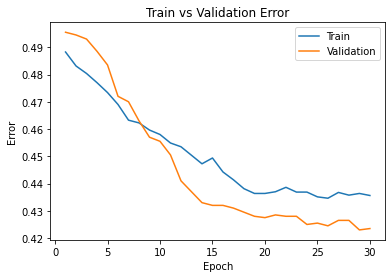

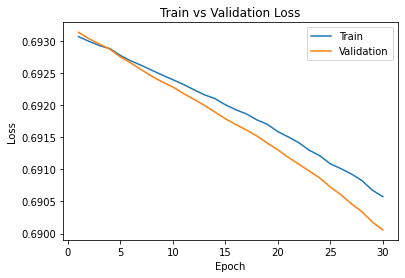

In [ ]:
model_path_large  = get_model_name("large", batch_size = 512, learning_rate = 0.001, epoch = 29)
plot_training_curve(model_path_large )

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

In [ ]:
# In my results above, the model is not overfitting, it fits the data well.
# In the previous training, the validatino error has been below 0.42. 
# But my model's training validation error is a little bit higher than that.
# Maybe the batch size and learning rate need to be adjusted.
# I want to decrease batch size and increase learning rate a little bit.
# Therefore, I will change the batch size smaller to 200 and change the learning rate larger to 0.008.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net,200, 0.008, 30)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.468625, Train loss: 0.6926155805587768 |Validation err: 0.433, Validation loss: 0.6918044149875641
Epoch 2: Train err: 0.44825, Train loss: 0.6911847651004791 |Validation err: 0.445, Validation loss: 0.6893435299396515
Epoch 3: Train err: 0.434625, Train loss: 0.6888546273112297 |Validation err: 0.418, Validation loss: 0.6856356918811798
Epoch 4: Train err: 0.43275, Train loss: 0.6854867398738861 |Validation err: 0.414, Validation loss: 0.6804765045642853
Epoch 5: Train err: 0.422875, Train loss: 0.6817651122808457 |Validation err: 0.4125, Validation loss: 0.6767330706119538
Epoch 6: Train err: 0.41675, Train loss: 0.6776930838823318 |Validation err: 0.414, Validation loss: 0.672452861070633
Epoch 7: Train err: 0.409125, Train loss: 0.673852787911892 |Validation err: 0.409, Validation loss: 0.6699672937393188
Epoch 8: Train err: 0.40125, Train loss: 0.670097428560257 |Validation err: 0.398

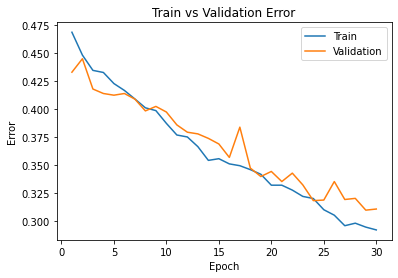

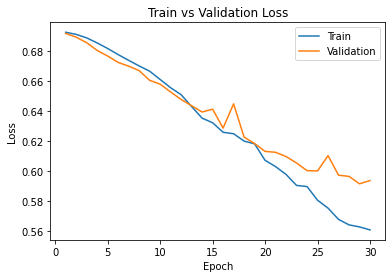

In [ ]:
model_path_large  = get_model_name("large", batch_size = 200, learning_rate = 0.008, epoch = 29)
plot_training_curve(model_path_large )

## Part 5. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=200, learning_rate=0.008, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

In [ ]:
# The model should generate the smallest erroe/loss values and not overfit in order to be the best model.

# From part4, I know larger batch size and smaller learning rate can help avoid overfitting.
# But too large batch size and too small learning rate may lead to larger value of loss/error value.
# From part4 last question, after adjusting the batch size and learning rate,  
# I notice that the model's training validation error is lower than before, which is smaller than before.
# Also, this model doesn't overfit. The curves show that it fits the data best.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=200)

error, loss = evaluate(net, test_loader, nn.BCEWithLogitsLoss())
print("test classification error is {}".format(error))
print("test classification loss is {}".format(loss))

Files already downloaded and verified
Files already downloaded and verified
test classification error is 0.3125
test classification loss is 0.5766732633113861


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
error, loss = evaluate(net, val_loader, nn.BCEWithLogitsLoss())
print("validation classification error is {}".format(error))
# The validation error is 0.312 and the test error is 0.3145. The test error is higher.
# The validation error is lower because the model is training to fit the data according
# to the validation dataset. The model is more familiar with validation dataset. 
# The validation accuracy should be better than testing accuracy.

validation classification error is 0.311


### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

Using the test data set more than once will eventually lead to bias because hyperparameters are adjusted for the best performance on the test set. We use the test data set to estimate the performance. The test set allows us to compare different models in an unbiased way, by basing the comparisons in data that were not use during the process of training/hyperparameter selection. Test set is to report the final accuracy and by means of "final", it can only be used once.



### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

The ANN has a higher test classification error and loss than the CNN.

CNN model fits our problem better because it's better at collecting local info.
The computed time of CNN is shorter than ANN because it has less  fully-connected layers.


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.423125, Train loss: 0.6725810691714287 |Validation err: 0.397, Validation loss: 0.6570630371570587
Epoch 2: Train err: 0.37925, Train loss: 0.6494615077972412 |Validation err: 0.391, Validation loss: 0.6519130229949951
Epoch 3: Train err: 0.370375, Train loss: 0.6382197737693787 |Validation err: 0.3805, Validation loss: 0.6487295866012573
Epoch 4: Train err: 0.360625, Train loss: 0.6310830101370811 |Validation err: 0.3835, Validation loss: 0.6491644740104675
Epoch 5: Train err: 0.353125, Train loss: 0.624605830013752 |Validation err: 0.375, Validation loss: 0.6437141239643097
Epoch 6: Train err: 0.340875, Train loss: 0.6164998978376388 |Validation err: 0.379, Validation loss: 0.6458338141441345
Epoch 7: Train err: 0.33075, Train loss: 0.6094016939401626 |Validation err: 0.378, Validation loss: 0.6432144224643708
Epoch 8: Train err: 0.32575, Train loss: 0.602860689163208 |Validation err: 0.

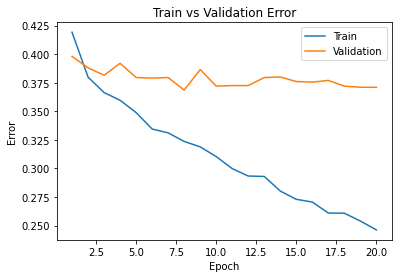

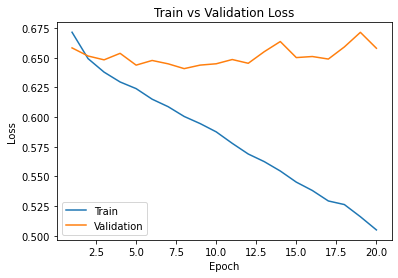

Files already downloaded and verified
Files already downloaded and verified
test classification error and loss: 0.368 0.7592902816832066


In [ ]:
# Lab 1 ANN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        self.name = "ANN"
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3 * 32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze()

# training
ANN = Pigeon()
train_net(ANN, 200, 0.008, 29)
model_path_ANN = get_model_name("ANN", batch_size=128, learning_rate=0.005, epoch=19)
plot_training_curve(model_path_ANN)

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size = 128)
error, loss = evaluate(ANN, test_loader, nn.BCEWithLogitsLoss())
print("test classification error and loss:", error, loss) 